# Scenario modelling

In [169]:
scn = "SCN_BASE"
BASELINE = "BASELINE"
SCN_BASE = "SCN_BASE"
SCN_MIN_LEY = "SCN_MIN_LEY"
SCN_REDUCED_MILK = "SCN_REDUCED_MILK"
SCN_SNG = "SCN_SNG"

SCENARIOS = [
    BASELINE,
    SCN_BASE,
    SCN_MIN_LEY,
    SCN_REDUCED_MILK,
    SCN_SNG,
]

## Set up environment

In [2]:
CM_BASEPATH = '../cibusmod'

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), CM_BASEPATH))

In [3]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import time
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [4]:
from CIBUSmod.utils.misc import inv_dict, aggregate_data_coords_pair
from CIBUSmod.optimisation.indexed_matrix import IndexedMatrix
from CIBUSmod.optimisation.utils import make_cvxpy_constraint
from itertools import product

In [5]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

In [6]:
def block_print(msg: str, N=80):
    print("=" * N)
    print("=" * N)
    if len(msg) >= N-2:
        print(msg)
    else:
        _n = int((N - len(msg)) / 2) - 1
        _n2 = _n + len(msg) % 2
        print(_n * "-" + f" {msg} " + "-" * _n2)
    print("=" * N)
    print("=" * N)

In [7]:
# Create session
session = cm.Session(
    name = 'main',
    data_path = "data",
    data_path_default = CM_BASEPATH + "/data/default",
)

## Share of land use per region

In [8]:
x0_lu_per_region = session.get_attr("r", "x0_crops", "region")
x_lu_per_region = session.get_attr("f", "x_crops", "region")
delta_lu_per_region = (x0_lu_per_region - x0_lu_per_region)

In [9]:
for _scn, year in delta_lu_per_region.index:
    if all(delta_lu_per_region == 0):
        block_print(f"{_scn}: All land used")
        print("")
    else:
        print(_scn)
        cm.plot.map_from_series(delta_lu_per_region[(_scn, year)])

--------------------------- BASELINE: All land used ----------------------------

--------------------------- SCN_BASE: All land used ----------------------------

-------------------------- SCN_MIN_LEY: All land used --------------------------

----------------------- SCN_REDUCED_MILK: All land used ------------------------

---------------------------- SCN_SNG: All land used ----------------------------



## Change in crops

Plots if crops increased or decarsed in amounts in each region.

### Change in total crops per region, compared to x0

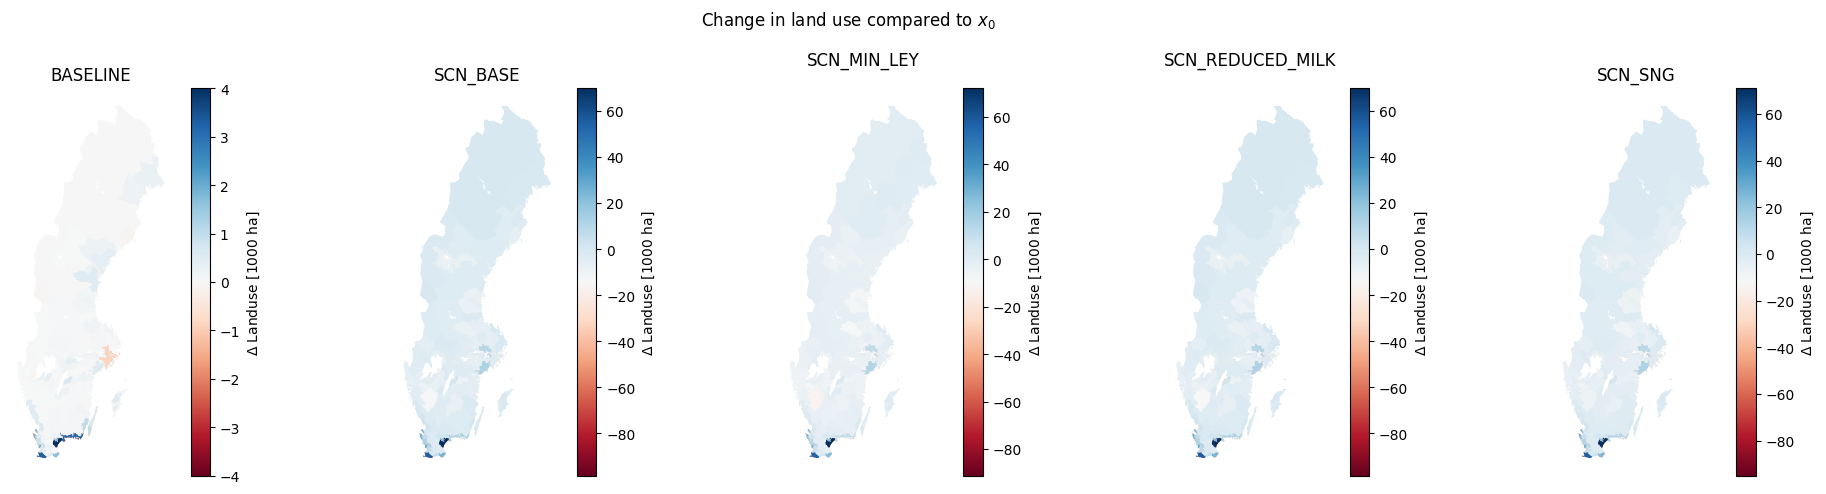

In [151]:
x0_crops_per_region = session.get_attr("r", "x0_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
x_crops_per_region = session.get_attr("f", "x_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
delta = x_crops_per_region - x0_crops_per_region

fig, axs = plt.subplots(1, len(session.scenarios()), figsize=(20, 5))
for scn, ax in zip(list(session.scenarios().keys()), axs):
    try:
        data = delta.loc[(scn, "2020"),:] / 1e3
    except Exception:
        continue
    
    ax.set_axis_off()
    ax.set_title(scn)
    plot.map_from_series(data, cmap="RdBu", ax=ax, legend_kwds={ "label": r"$\Delta$ Landuse [1000 ha]" })

fig.suptitle(r"Change in land use compared to $x_0$")
fig.tight_layout()

### Change in total crops per region, compared to the baseline

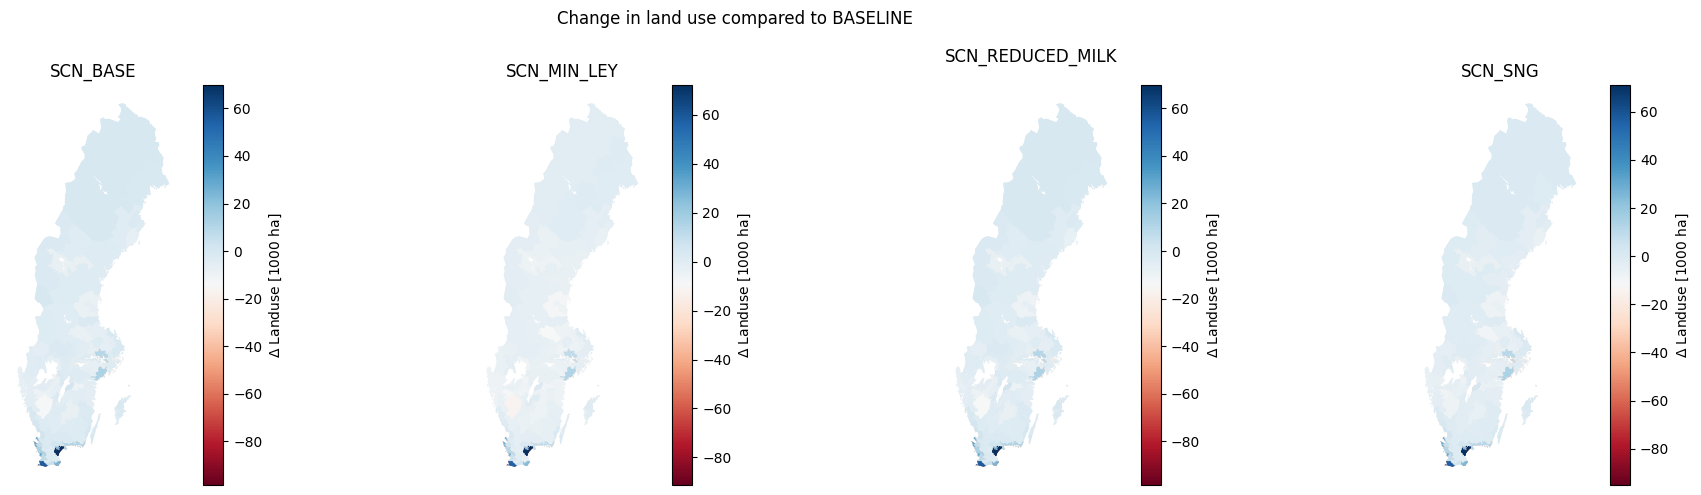

In [152]:
BL_crops_per_region = session.get_attr("r", "x0_crops", ["prod_system", "region"], scn="BASELINE").loc[("BASELINE","2020")]
SCNS_crops_per_region = session.get_attr("f", "x_crops").drop(columns=[("Wheat (add)",), ("Peas (add)",)]).T.groupby(["prod_system", "region"]).sum().T
SCNS_crops_per_region = SCNS_crops_per_region.drop([("BASELINE", "2020")])
delta = SCNS_crops_per_region - BL_crops_per_region

scenarios = [s for s in session.scenarios().keys() if s != "BASELINE"]
fig, axs = plt.subplots(1, len(scenarios), figsize=(20, 5))
for scn, ax in zip(scenarios, axs):
    ax.set_axis_off()
    ax.set_title(scn)
    
    try:
        data = delta.loc[(scn, "2020"),:] / 1e3
    except Exception:
        continue
    
    plot.map_from_series(data, cmap="RdBu", ax=ax, legend_kwds={ "label": r"$\Delta$ Landuse [1000 ha]" })

fig.suptitle("Change in land use compared to BASELINE")
fig.tight_layout()

## Share of byproducts used

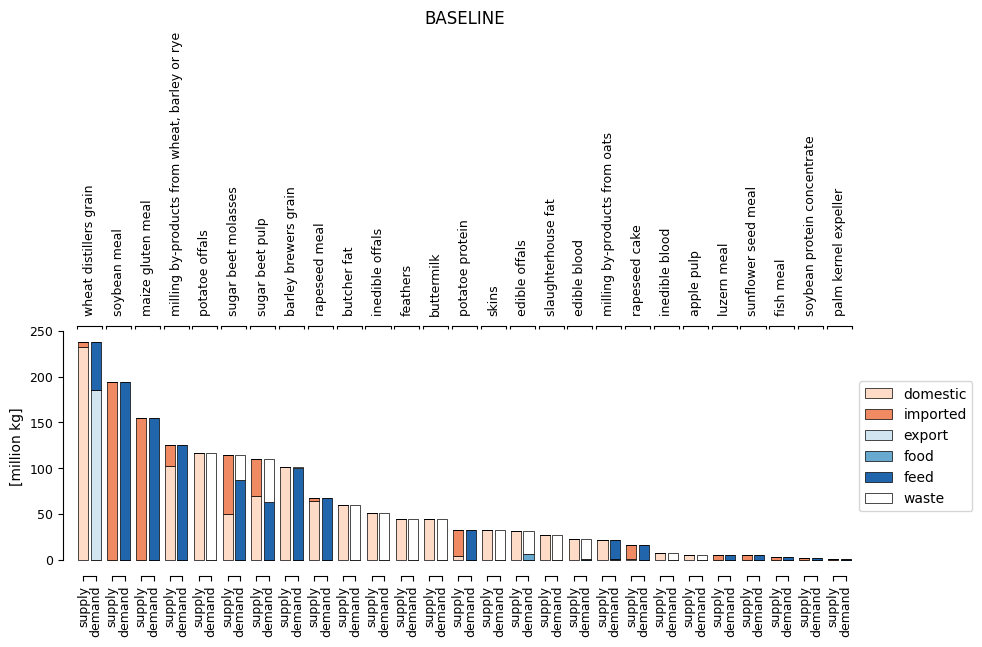

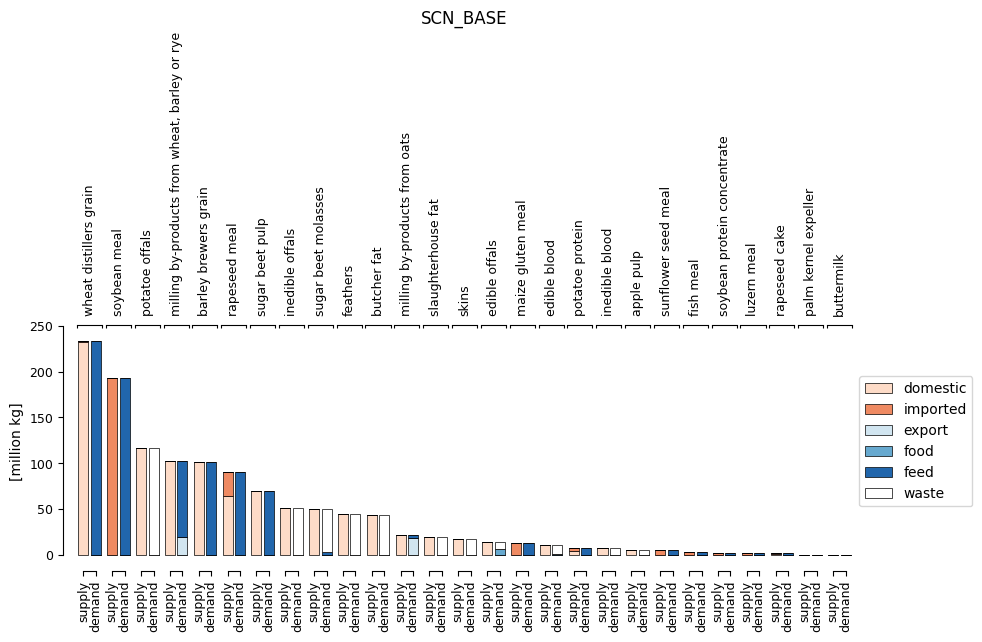

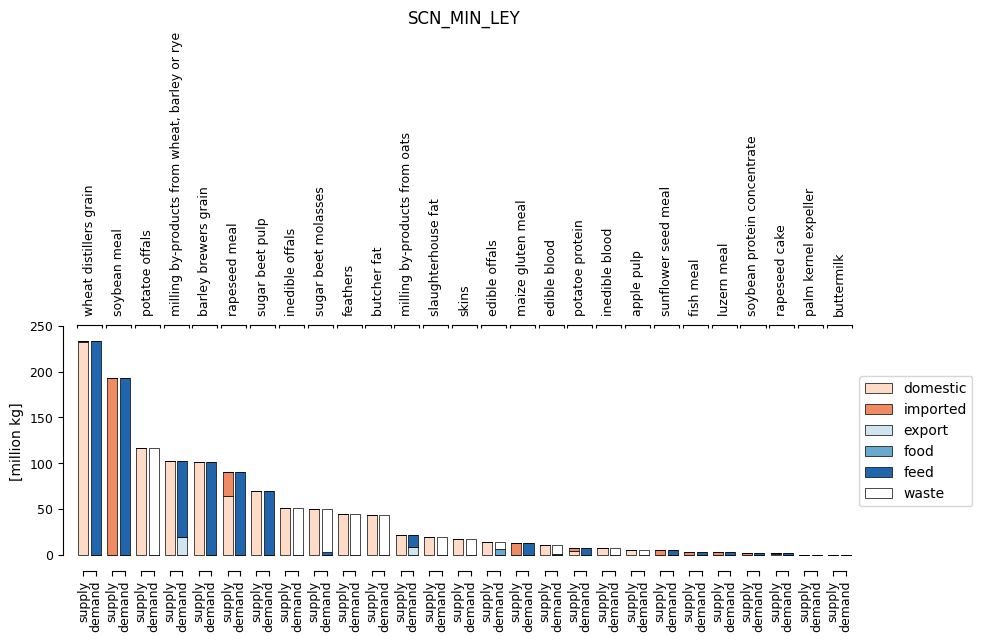

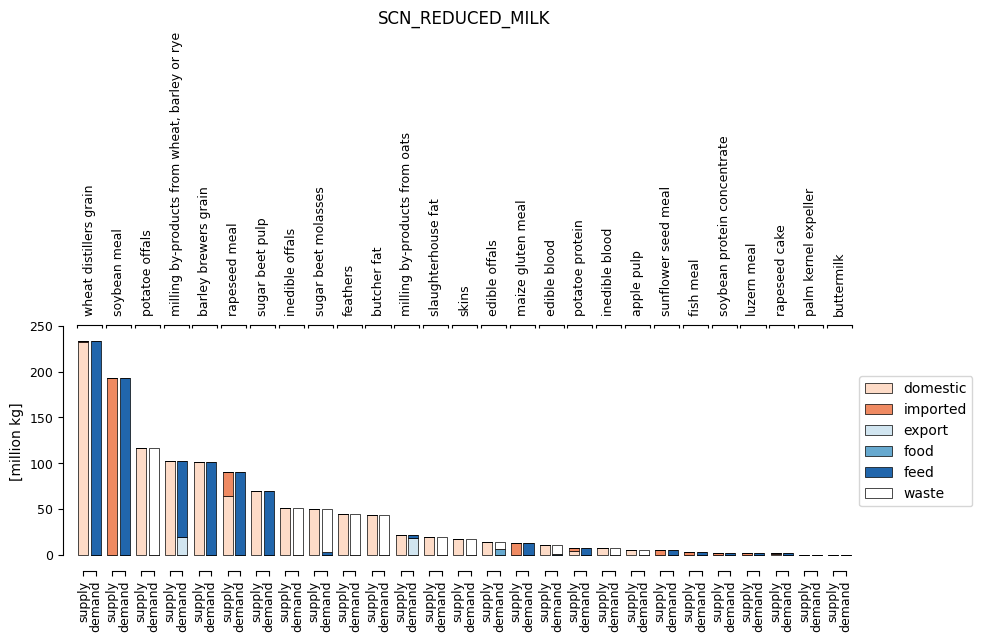

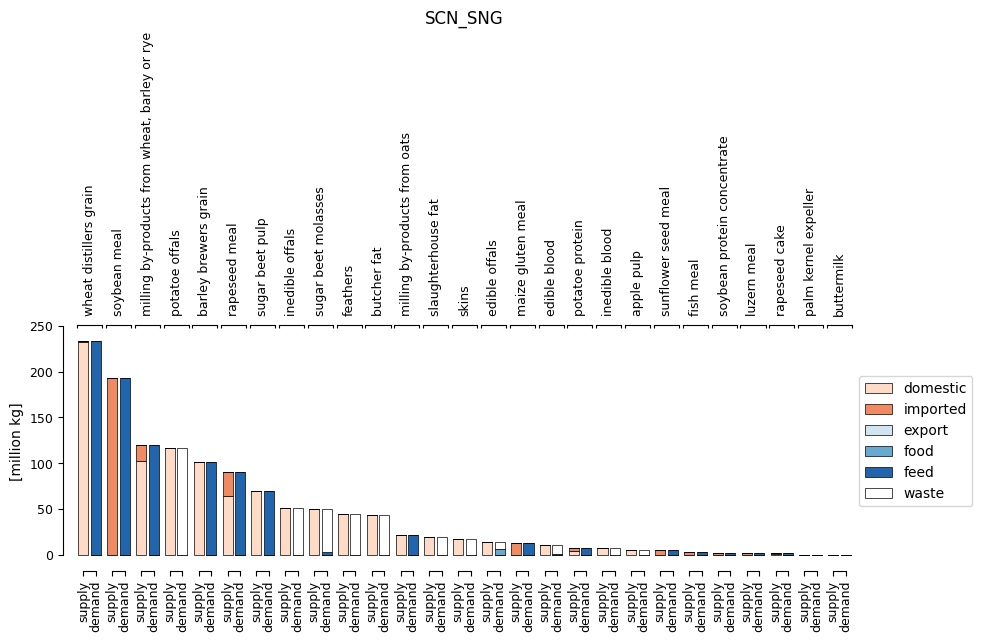

In [178]:
from matplotlib.colors import ListedColormap

for scn in SCENARIOS:
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    use = pd.concat([
        # By product demand
        session.get_attr('D', 'by_prod_demand', ['by_prod', 'demand']).loc[(scn,year)].unstack(fill_value=0),
        # Feed
        session.get_attr('A', 'feed.by_product_demand', 'by_prod')
        .loc[(scn,year)]
        .rename('feed'),
        # Waste
        session.get_attr('D', 'by_prod_to_waste', 'by_prod').loc[(scn,year)]
        .rename('waste')
    ], axis=1).fillna(0).rename_axis('origin', axis=1)
    
    supply = (
        session.get_attr('D', 'by_products', ['by_prod', 'origin'])
        .loc[(scn,year)]
        .unstack()
        .fillna(0)
    )
    
    plot_data = (
        pd.concat([
            pd.concat({'supply': supply}, names=['flow'], axis=1),
            pd.concat({'demand': use }, names=['flow'], axis=1),
        ], axis=1)
        .stack('flow')
        .sort_index(level='flow', ascending=False)
        .sort_index(level='by_prod', sort_remaining=False)
        .fillna(0)
        / 1e6
    )
    
    colors = ['#fddbc7', '#ef8a62', '#d1e5f0', '#67a9cf', '#2166ac', '#ffffff']
    cust_cmap = ListedColormap(name='X', colors=colors)
    
    ax, axgs = cm.plot.bar(
        plot_data.drop('whey'),
        ax=ax,
        cmap = cust_cmap,
        group_levels='by_prod',
        sort_groups=True,
        grouplabels_vertical=True,
        group_spacing = 0.3,
        ticklabels_fontsize = 9,
        grouplabels_fontsize = 9,
        ylabel_fontsize = 10,
        xlabel_fontsize = 10
    )
    ax.set_ylabel("[million kg]")
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set_title(scn)
    fig.show()


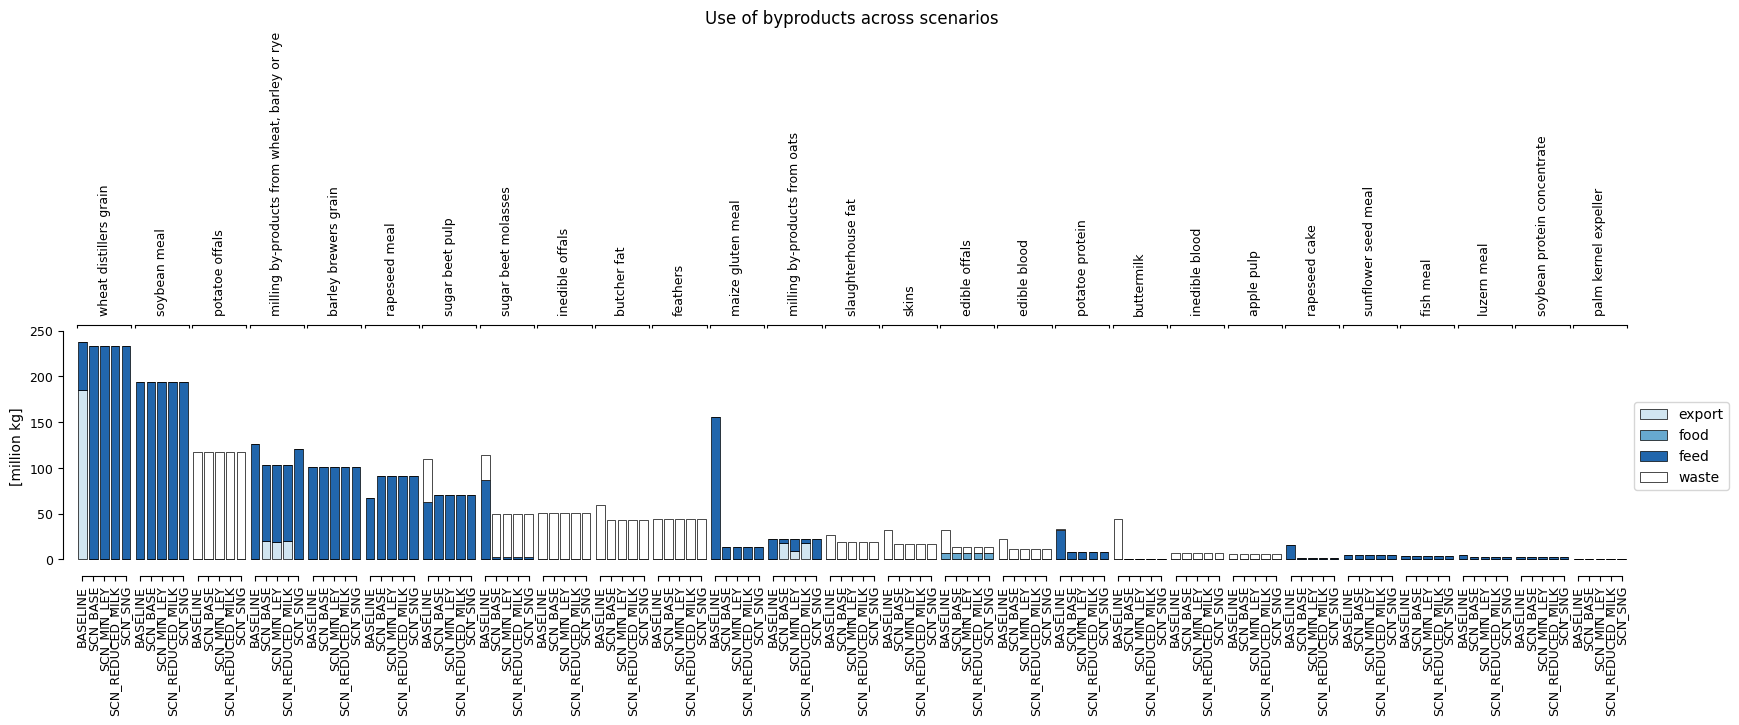

In [187]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(1, 1, figsize=(20, 3))
def get_use(scn: str):
    return pd.concat([
        # By product demand
        session.get_attr('D', 'by_prod_demand', ['by_prod', 'demand']).loc[(scn,year)].unstack(fill_value=0),
        # Feed
        session.get_attr('A', 'feed.by_product_demand', 'by_prod')
        .loc[(scn,year)]
        .rename('feed'),
        # Waste
        session.get_attr('D', 'by_prod_to_waste', 'by_prod').loc[(scn,year)]
        .rename('waste')
    ], axis=1).fillna(0).rename_axis('origin', axis=1)

plot_data = (
    pd.concat([
        pd.concat({scn: get_use(scn)}, names=['flow'], axis=1) 
        for scn in SCENARIOS
    ], axis=1)
    .stack('flow')
    .sort_index(level='flow', ascending=True)
    .sort_index(level='by_prod', sort_remaining=False)
    .fillna(0)
    / 1e6
)

colors = ['#d1e5f0', '#67a9cf', '#2166ac', '#ffffff']
cust_cmap = ListedColormap(name='X', colors=colors)

ax, axgs = cm.plot.bar(
    plot_data.drop('whey'),
    ax=ax,
    cmap = cust_cmap,
    group_levels='by_prod',
    sort_groups=True,
    grouplabels_vertical=True,
    group_spacing = 0.3,
    ticklabels_fontsize = 9,
    grouplabels_fontsize = 9,
    ylabel_fontsize = 10,
    xlabel_fontsize = 10
)
ax.set_ylabel("[million kg]")
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title("Use of byproducts across scenarios")
fig.show()


crop,Wheat (add),Peas (add)
scn,,
SCN_BASE,5459.926230,1155.989687
SCN_MIN_LEY,3053.061376,1151.521905
SCN_REDUCED_MILK,5497.437861,1156.028405
SCN_SNG,4678.422110,1151.610956


animal_prod,milk,meat
scn,,
BASELINE,2817.159560,543.862707
SCN_BASE,1819.319156,455.459823
SCN_MIN_LEY,1912.755964,546.823085
SCN_REDUCED_MILK,1579.778714,459.782017
SCN_SNG,1819.319156,485.670868


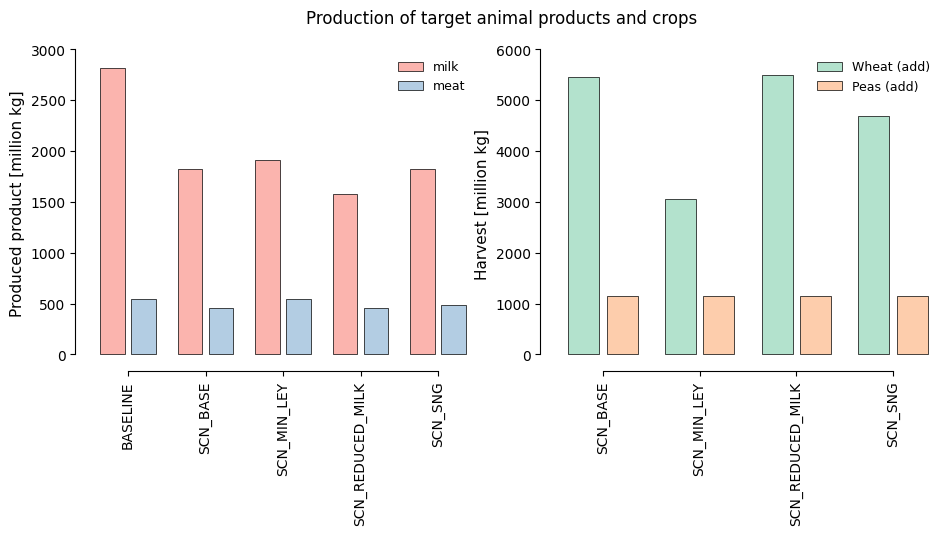

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

meatmilk_prod = (
    session.get_attr('a', 'production', "animal_prod")[["milk", "meat"]]
    .droplevel("year") 
    / 1e6
)
plot.bar(meatmilk_prod, stacked=False, ax=ax1, cmap="Pastel1")
ax1.set_ylabel("Produced product [million kg]")

crop_prod = session.get_attr("c", "harvest", "crop")[["Wheat (add)", "Peas (add)"]].droplevel("year") / 1e6
crop_prod = crop_prod.drop("BASELINE")
plot.bar(crop_prod, stacked=False, ax=ax2, cmap="Pastel2")
ax2.set_ylabel("Harvest [million kg]")

fig.suptitle("Production of target animal products and crops")

display(crop_prod)
display(meatmilk_prod)

## Chloropleth maps over added crops/meat

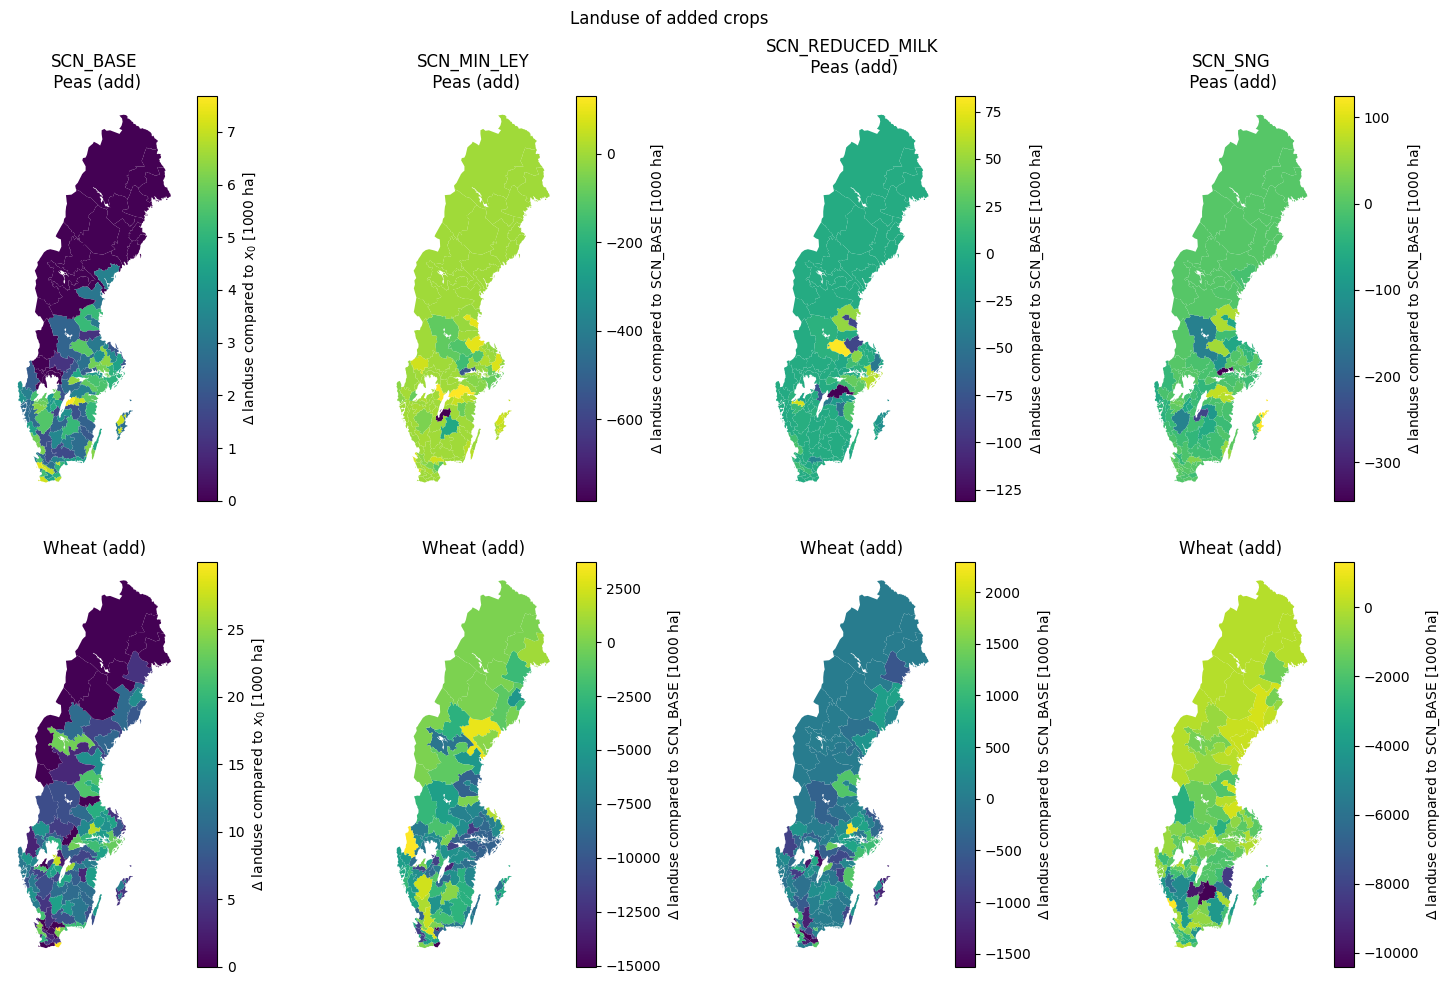

In [150]:
def get_x(crp: str):
    return session.get_attr("f", "x_crops").xs(crp, level="crop", drop_level=False, axis=1).droplevel("year")

crops = pd.concat([get_x("Peas (add)"), get_x("Wheat (add)")], axis=1)
cps = crops.columns.unique("crop")
crops = crops.drop("BASELINE")

nrows = len(cps)
ncols = crops.shape[0]
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*5))

if nrows == 1:
    axs = [axs]

for scn_i, scn in enumerate(crops.index):
    for crp_i, crp in enumerate(cps):
        data=crops.loc[scn,(crp, "conventional",)]
        ax=axs[crp_i][scn_i]
        ax.set_axis_off()
        title = crp
        if crp_i == 0:
            title = f"{scn}\n {title}"
        ax.set_title(title)

        if scn == "SCN_BASE":
            cm.plot.map_from_series(data / 1e3, ax=ax, legend_kwds={ "label": r"$\Delta$ landuse compared to $x_0$ [1000 ha]" })
        else:
            data = data - crops.loc["SCN_BASE",(crp, "conventional",)]
            cm.plot.map_from_series(data, ax=ax, legend_kwds={ "label": r"$\Delta$ landuse compared to SCN_BASE [1000 ha]"  })

fig.suptitle("Landuse of added crops")
fig.tight_layout()


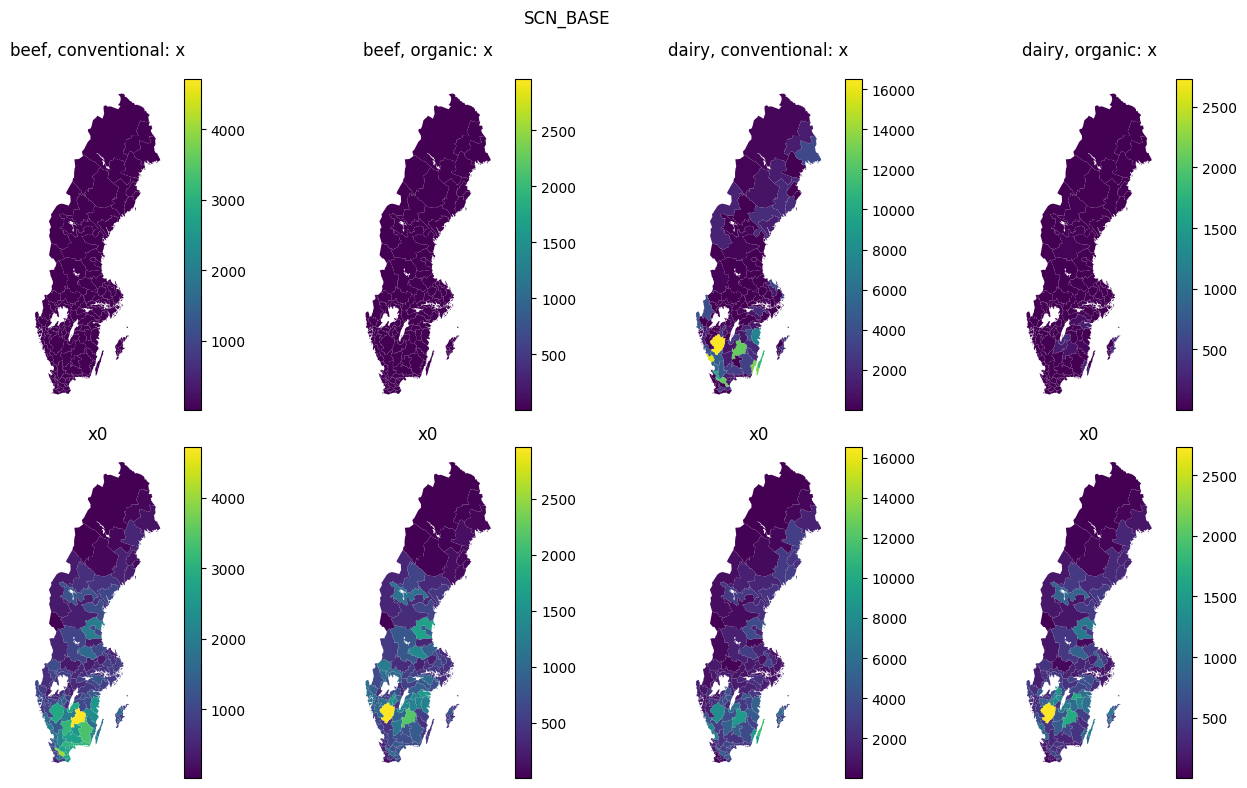

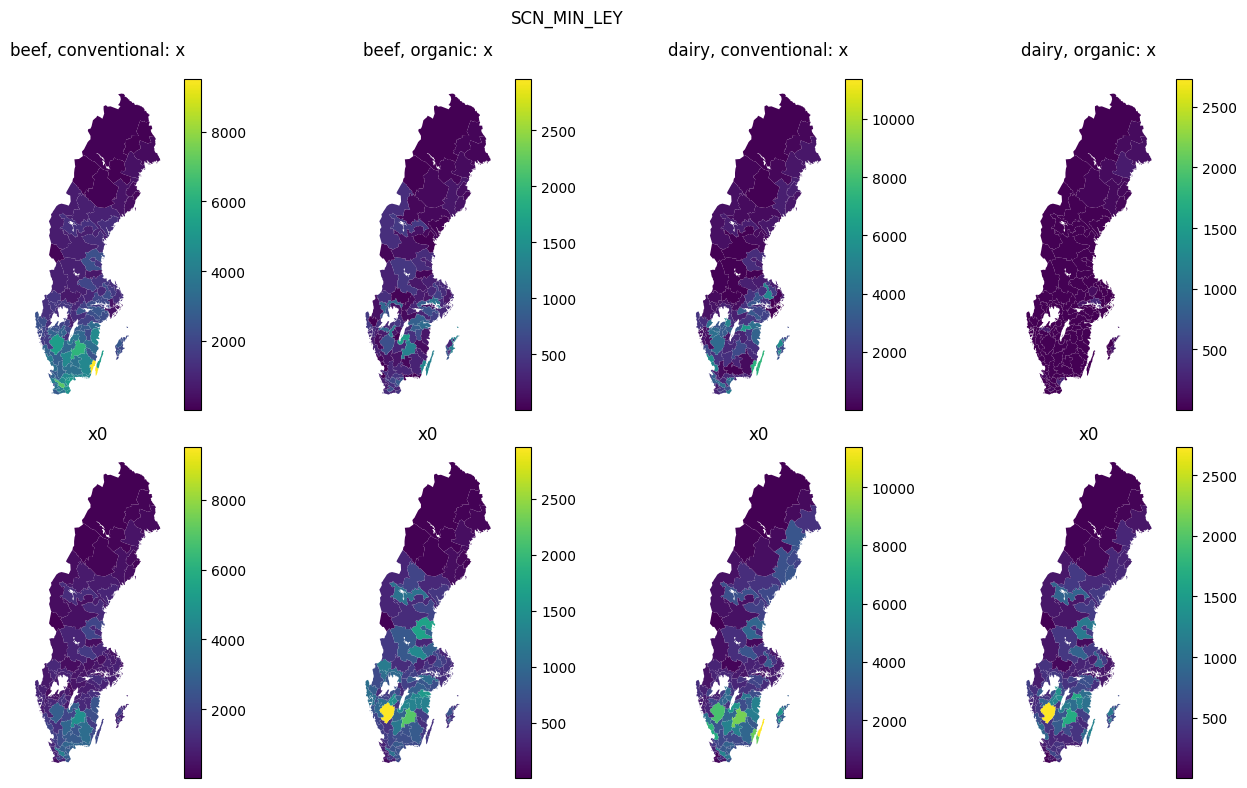

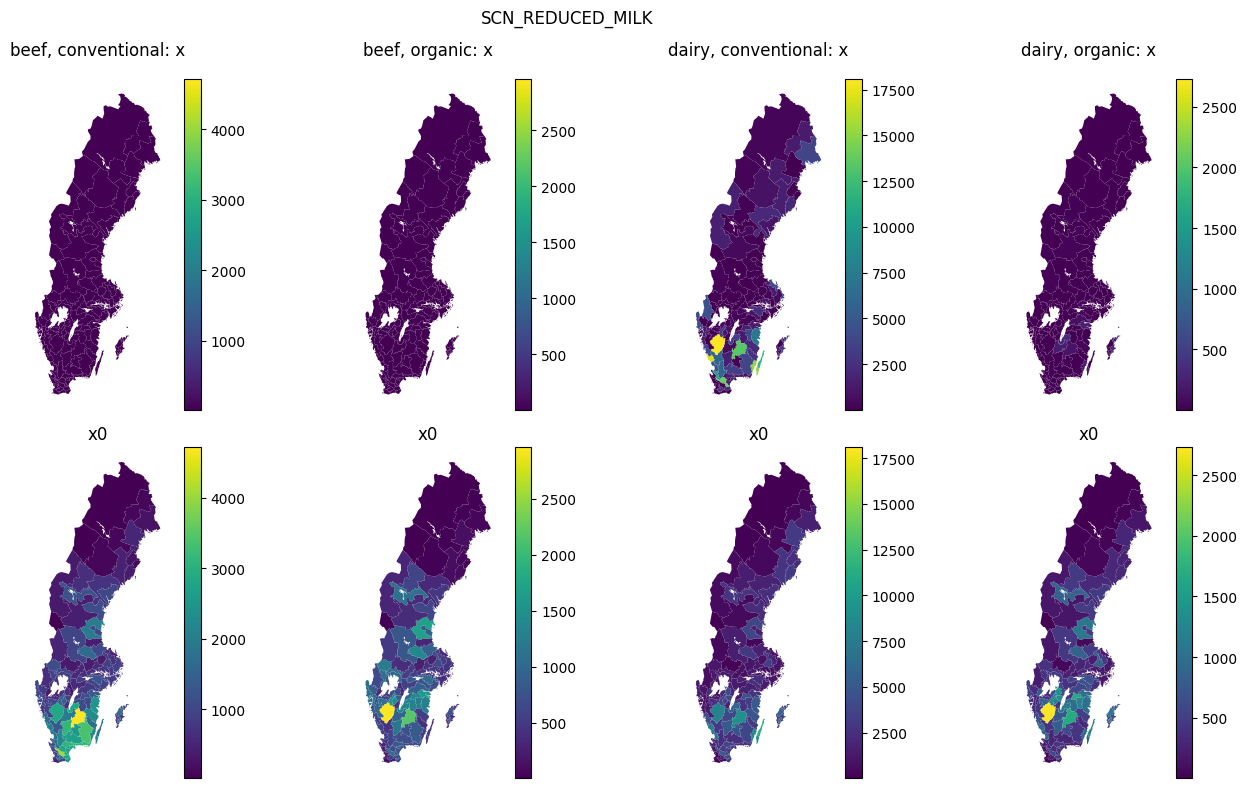

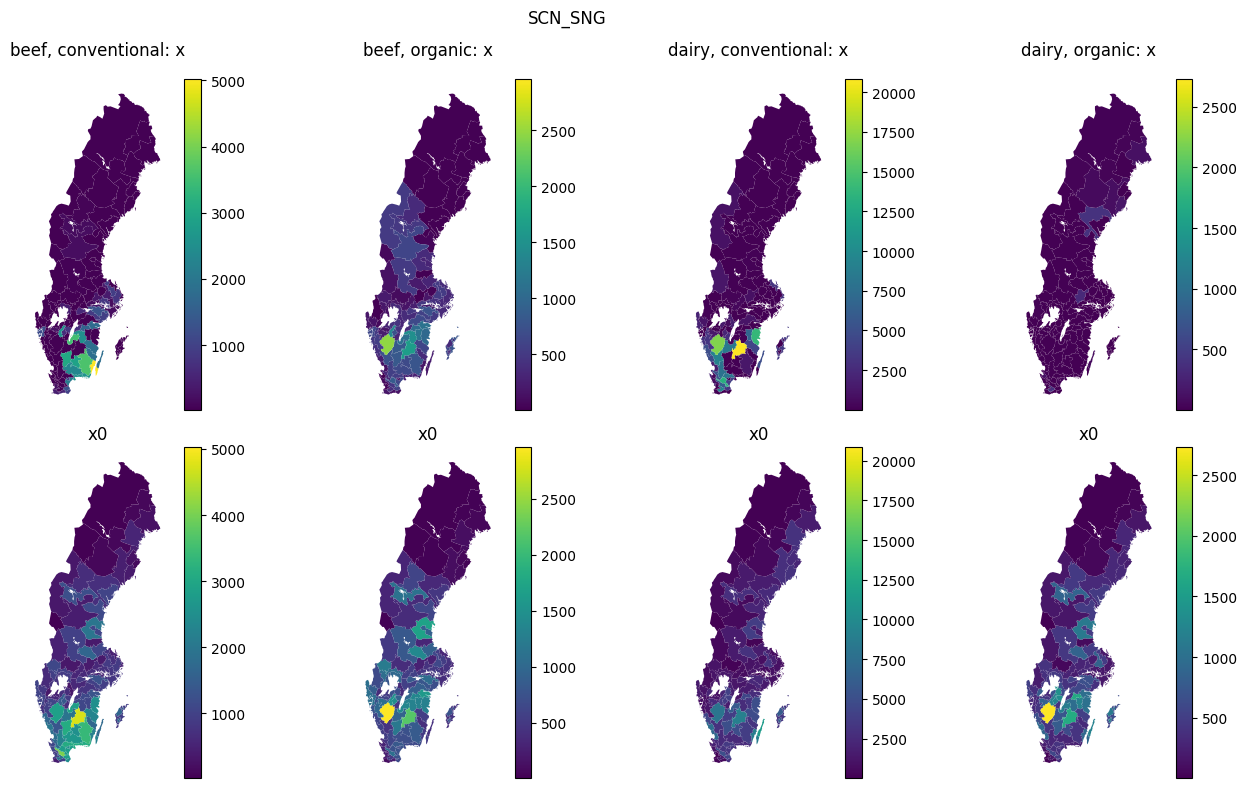

In [202]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

all_x0_cattle = session.get_attr("r", "x0_animals").xs("cattle", level="species", axis=1)
all_x_cattle = session.get_attr("f", "x_animals", ["species", "breed", "prod_system", "region"]).xs("cattle", level="species", axis=1)

for scn in all_x_cattle.index.get_level_values("scn"):
    if scn == "BASELINE": 
        continue
    
    x0_cattle = all_x0_cattle.loc[(scn, "2020")].unstack("region")
    x_cattle = all_x_cattle.loc[(scn, "2020")].unstack("region")
    
    assert (x0_cattle.index == x_cattle.index).all(), "Expected index of x0 and x to match"
    
    N = len(x0_cattle.index.values)
    fig, axes2d = plt.subplots(2, N, figsize=(N * 3.5, 8))
    
    for pos, axs in zip(x0_cattle.index, axes2d.T):
        (ax_x, ax_x0) = axs
        
        x = x_cattle.loc[pos,:]
        x0 = x0_cattle.loc[pos,:]
    
        # Absolute values: x and x0
        # -------------------------
        ax_x.set_axis_off()
        ax_x0.set_axis_off()
        x_vmax = max(x.max(), x0.max())
        x_vmin = max(x.min(), x0.min())
        ax_x.set_title(f"{pos[0]}, {pos[1]}: x")
        ax_x0.set_title("x0")
        cm.plot.map_from_series(x, ax=ax_x, vmin=x_vmin, vmax=x_vmax)
        cm.plot.map_from_series(x0, ax=ax_x0, vmin=x_vmin, vmax=x_vmax)

    fig.suptitle(scn)
    fig.tight_layout()
    plt.show()

# Impacts

## Greenhouse gases

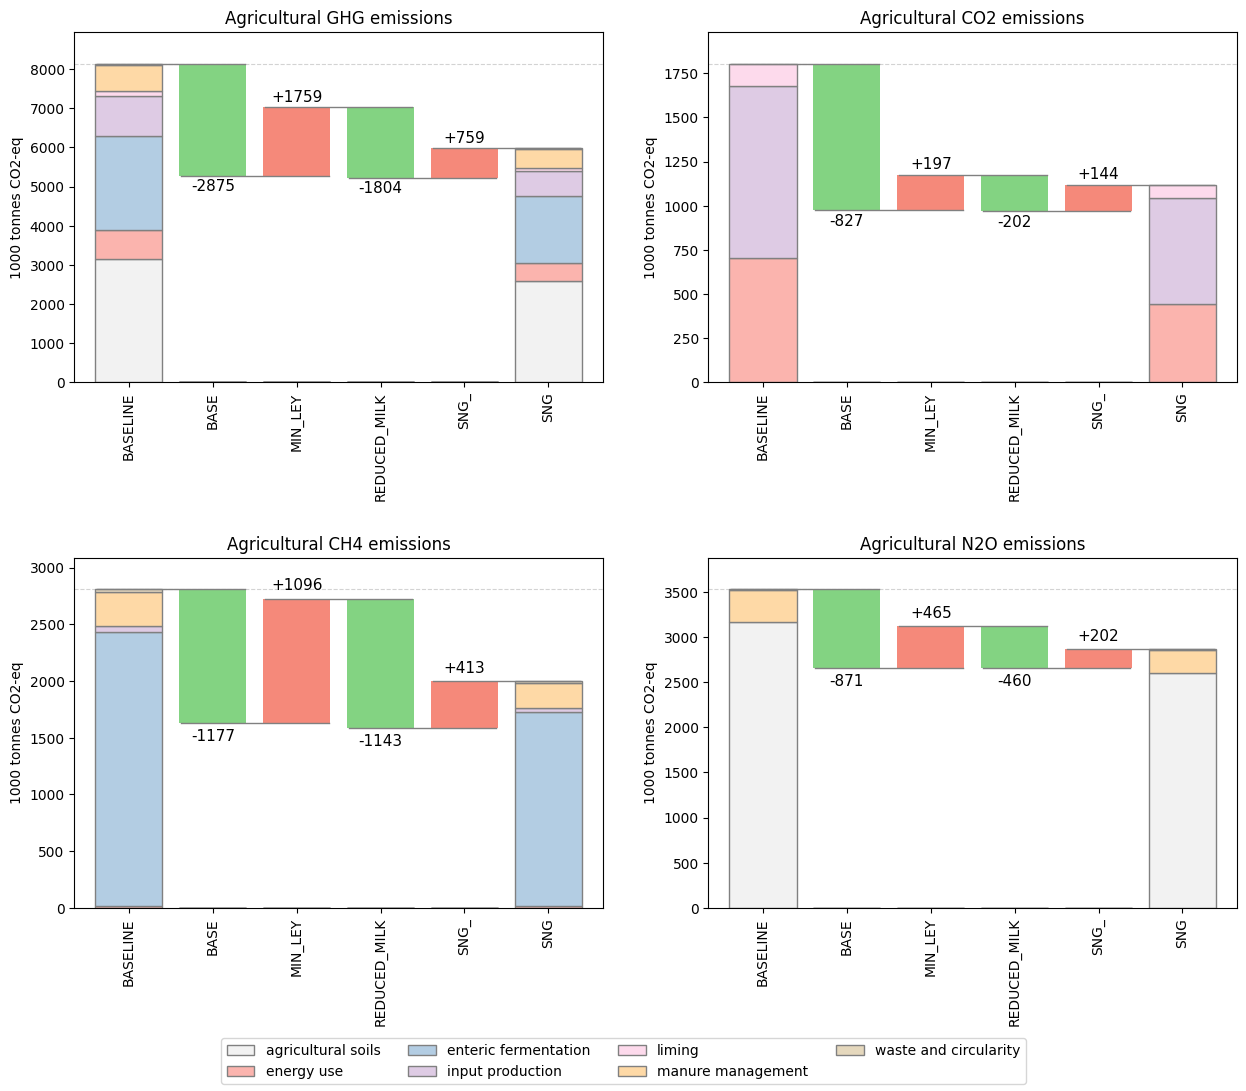

In [84]:
ghg_impacts = (
    cm.impact.get_GHG(session)
    .T.groupby(['compound','process']).sum().T
    .droplevel('year')
)/1e6

def plot_ghg(
    ghgs: list[str] | str | slice,
    title: str,
    ax: plt.Axes | None = None,
    color_map: dict[str, tuple] | None = None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,6))

    if isinstance(ghgs, str):
        ghgs = [ghgs]

    data = ghg_impacts.loc[:,ghgs].T.groupby('process').sum().T

    # Default to cmap, but use explicit color assignment if color_map is passed
    kwargs = { "cmap": cmap }
    if color_map:
        categories = data.columns.unique("process")
        kwargs["color"]=[color_map[cat] for cat in categories]
        del kwargs["cmap"]
        
    plot.waterfall(
        data=data,
        ax=ax,
        edgecolor='grey',
        width=0.8,
        label='absolute',
        **kwargs
    )

    ax.axhline(
        y=data.sum(axis=1).loc["BASELINE"],
        xmin=0, xmax=1, zorder=0, 
        linestyle='--', linewidth=0.8, color='lightgrey'
    )

    ax.set_title(title)
    ax.tick_params(axis='y', which='major')
    ax.set_xlabel('')
    ax.set_ylabel('1000 tonnes CO2-eq')
    ax.set_ylim(top=data.sum(axis=1).max()*1.1)
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

# Create a dict mapping category -> color so that we get consistent color-assignments across
# all subplots (e.g. 'energy use' always has the same color)
categories = ghg_impacts.columns.unique("process").values
cmap = plt.get_cmap('Pastel1', len(categories))
color_map = {category: cmap(i) for i, category in enumerate(categories)}

# Draw plots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
plot_ghg(pd.IndexSlice[:], title="Agricultural GHG emissions", ax=axs[0][0], color_map=color_map)
plot_ghg("CO2", title="Agricultural CO2 emissions", ax=axs[0][1], color_map=color_map)
plot_ghg(["CH4bio", "CH4fos"], title="Agricultural CH4 emissions", ax=axs[1][0], color_map=color_map)
plot_ghg(["N2O", "N2Oind"], title="Agricultural N2O emissions", ax=axs[1][1], color_map=color_map)

# Adjust plots
# ------------

## Remove all the subplot-legends and add a common one for the entire figure
co2e_handles, co2e_labels = axs[0][0].get_legend_handles_labels() 
[ax.get_legend().remove() for ax in axs.reshape(-1)]
fig.legend(co2e_handles, co2e_labels, loc="lower center", ncol=4)

## Remove SCN_ as prefix from xtick-labels to get save space
for ax in axs.reshape(-1):
    ax.set_xticklabels([
        item.get_text().removeprefix("SCN_") 
        for item in ax.get_xticklabels()
    ])

## Control the spacing 
fig.subplots_adjust(wspace=0.2, hspace=0.5, bottom=.15)

## Cropland use

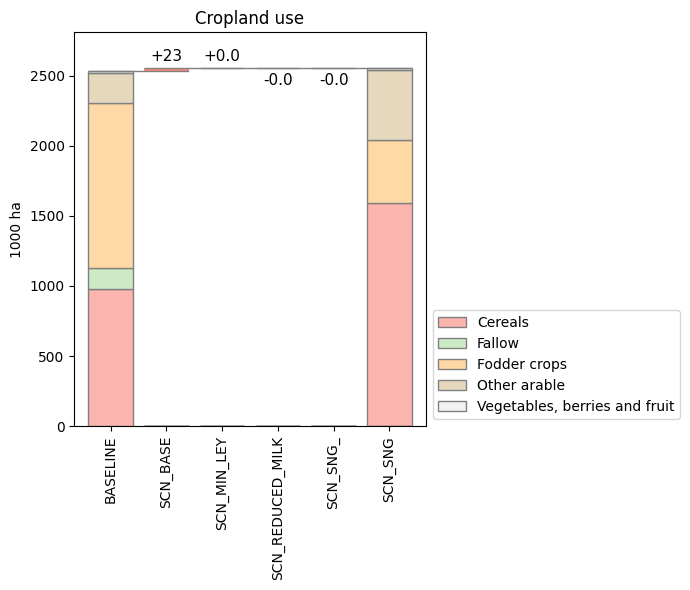

In [86]:
fig, ax = plt.subplots(figsize=(7,6))

plot_data2 = (
    (session.get_attr('C','area',groupby={'crop':'crop_group2'})/1000)
    .drop(['Greenhouse crops','Semi-natural grasslands'], axis=1)
    .droplevel('year')
)

plot.waterfall(
    data=plot_data2,
    ax=ax,
    breaks = ['FAI (demand)'],
    cmap='Pastel1',
    edgecolor='grey',
    width=0.8,
    label='absolute'
)

ax.set_title('Cropland use')
ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel('1000 ha')
ax.set_ylim(top=plot_data2.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
plt.show()

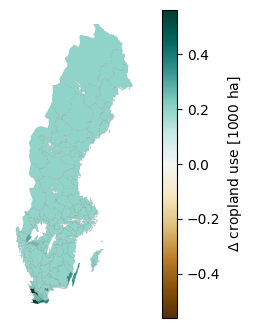

In [89]:
plot_data = (
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    /1000
)
plot_data = (plot_data - plot_data.loc[('BASELINE','2020')])

fig,ax = plt.subplots(figsize=(6,4))

map_data = plot_data.iloc[-1]
lim = abs(map_data).quantile(0.99)
plot.map_from_series(map_data, ax=ax, vmin=-lim, vmax=lim, cmap='BrBG', edgecolor='grey', legend_kwds={'label': r'$\Delta$ cropland use [1000 ha]'})
ax.axis('off')

plt.show()


## Mineral N use

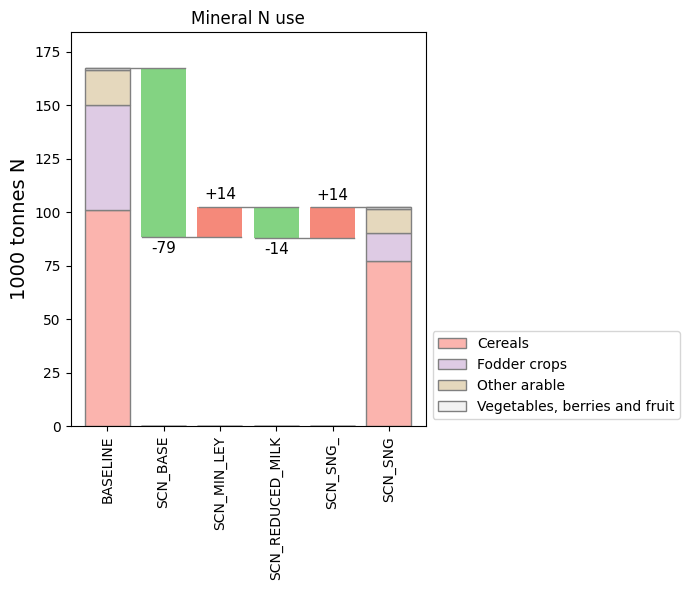

In [87]:
fig, ax = plt.subplots(figsize=(7,6))

plot_data3 = (
    (session.get_attr('C','fertiliser.mineral_N',groupby={'crop':'crop_group2'})/1000000)
    .drop(['Greenhouse crops','Semi-natural grasslands'], axis=1, errors='ignore')
    .droplevel('year')
)

plot.waterfall(
    data=plot_data3,
    ax=ax,
    breaks = ['FAI (demand)'],
    cmap='Pastel1',
    edgecolor='grey',
    width=0.8,
    label='absolute'
)

ax.set_title('Mineral N use')
ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel('1000 tonnes N', size=14)
ax.set_ylim(top=plot_data3.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
plt.show()

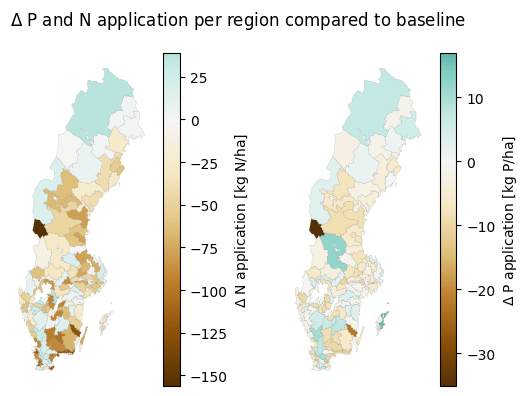

In [103]:
# CHANGES IN N AND P APPLICATION

plot_data_N = (
    (session.get_attr('C','fertiliser.manure_N',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    + session.get_attr('C','fertiliser.mineral_N',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1))
    /
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
)
plot_data_N = (plot_data_N - plot_data_N.loc[('BASELINE','2020')])

plot_data_P = (
    (session.get_attr('C','fertiliser.manure_P',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
    + session.get_attr('C','fertiliser.mineral_P',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1))
    /
    session.get_attr('C','area',{'region':None,'crop':'land_use'}).xs('cropland', level='land_use', axis=1)
)
plot_data_P = (plot_data_P - plot_data_P.loc[('BASELINE','2020')])

fig,axs = plt.subplots(1,2, figsize=(6,4))

styles = { 
    "cmap": "BrBG",
    "cmap_zero_midpoint": "shrink",
    "edgecolor": "grey"
}

for map_data, ax, label in [
    (plot_data_N.iloc[-1], axs[0], r'$\Delta$ N application [kg N/ha]'),
    (plot_data_P.iloc[-1], axs[1], r'$\Delta$ P application [kg P/ha]'),
]:
    lim = abs(map_data).quantile(0.99)
    plot.map_from_series(map_data, ax=ax, legend_kwds={'label': label}, **styles)
    ax.axis('off')

fig.suptitle(r"$\Delta$ P and N application per region compared to baseline")
fig.tight_layout()
plt.show()